In [1]:
!pip install xgboost

In [78]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle

import numpy as np
from pprint import pprint
import pandas as pd
import os
import time
import gc
import random
from tqdm._tqdm_notebook import tqdm_notebook as tqdm




import torch.utils.data
from tqdm import tqdm
import warnings

from nltk.tokenize.treebank import TreebankWordTokenizer
from scipy.stats import rankdata

from gensim.models import KeyedVectors
import gensim.downloader as api


from scipy.stats import rankdata

import gc
import pandas as pd

from scipy.sparse import csr_matrix, hstack

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

import os 
import re
import numpy as np
import sklearn
from sklearn.model_selection import cross_validate

from  sklearn.model_selection import cross_val_predict
import string

import string
import swifter

import xgboost as xgb
from xgboost.sklearn import XGBClassifier # <3
from sklearn.model_selection import train_test_split
import gc
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import warnings


from sklearn.pipeline import make_pipeline

warnings.filterwarnings("ignore")
CRAWL_EMBEDDING_PATH ='./input/emb/cc.ru.300.pickle'

In [79]:
sorted(sklearn.metrics.SCORERS.keys()) 

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [80]:
Data_dir = './input/vk-cup/vkcup/'

In [81]:
gc.collect()
train = pd.read_csv(os.path.join(Data_dir,"train.csv") ,sep=";")
test = pd.read_csv(os.path.join(Data_dir,"test.csv") )
print(min(train.ID), max(train.ID))
data= pd.read_csv(os.path.join(Data_dir,"data.csv") ,sep=";")
bs_df = pd.read_csv(os.path.join(Data_dir,"baseline_solution.csv"), header = None)




adding_train = pd.read_csv(os.path.join(Data_dir,'addtrain.csv') )
adding_data = pd.read_csv(os.path.join(Data_dir,"adddata.csv") )


adding_train2 = pd.read_csv(os.path.join(Data_dir,'addtrain2.csv') )
adding_data2 = pd.read_csv(os.path.join(Data_dir,"adddata2.csv") )


adding_train = pd.concat([adding_train, adding_train2
                  ]).sample(frac=1,random_state=1234)
adding_data = pd.concat([adding_data, adding_data2
                  ]).sample(frac=1,random_state=1234)



train = pd.concat([train, adding_train
                  ]).sample(frac=1,random_state=1234)
data  = pd.concat([data,adding_data])



train = train.merge(data, left_on='ID', right_on='ID')
test =test.merge(data, left_on='ID', right_on='ID')


voprtest = test['Question'].copy()
voprtrain = train['Question'].copy()


1 30000


In [82]:
print(train.shape, test.shape)

(41868, 3) (11087, 2)


In [83]:

erste = train[ (train.Answer.isin([1]))]

zweite = erste[(train.Question.isin(test.Question.values))]['Question']

In [84]:
IDSTESTS = list(test[test.Question.isin(zweite)]['ID'])

In [85]:
fix_ids = test[test.Question.isin(zweite.values)].sort_values(by=["Question"])['ID']

In [86]:
data.head()

,ID,Question
0,1,Как зовут лодочника на реке Стикс в древнегреч...
1,2,Как в химии обозначается свинец?
2,3,Какой химический элемент преобладает в составе...
3,4,Кто из перечисленных был пажом во времена Екат...
4,5,Когда началась 2 мировая война?


# Prep

In [87]:
def regex(x):
    
    x.replace('\n', ' \n')
    
    
    #x += " "+ str(len(x))
    #print(x)
    d = x#.lower()
    
    result = []
    word = ''
    rus = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя0123456789'
          
    for char in d:
        if char not in string.whitespace:
            if char not in string.ascii_letters + "'"+   rus :
                if word:
                        result.append(word)
                result.append(char)
                word = ''
            else:
                word = ''.join([word,char])

        else:
            if word:
                result.append(word)
                word = ''
    word = ' '.join(result)
    
    x = word
    x = x.replace('. . .','...')
    x = x.replace('. .','..')
    x = x.replace('\ n', '\n')
    return x
    

In [88]:
data =  data.Question.apply(lambda x: regex(x))
train['Question'] = train.Question.apply(lambda x: regex(x))
test['Question'] = test.Question.apply(lambda x: regex(x))


In [89]:
data.head()

0    Как зовут лодочника на реке Стикс в древнегреч...
1                    Как в химии обозначается свинец ?
2    Какой химический элемент преобладает в составе...
3    Кто из перечисленных был пажом во времена Екат...
4                     Когда началась 2 мировая война ?
Name: Question, dtype: object

In [90]:
all_word = data.str.split(expand=True).stack().value_counts()

In [91]:
less = []

more = []

In [92]:
all_word = all_word.to_dict()

In [93]:

for i in all_word.keys():
    if all_word[i] > 2:
        more.append(i)
    else:
        less.append(i)

In [94]:
all_word

{'?': 44732,
 'в': 15316,
 ',': 13066,
 'В': 6235,
 'из': 6065,
 '.': 5905,
 '"': 5390,
 'Как': 5230,
 'на': 5091,
 '-': 4955,
 '|': 4765,
 'Кто': 4605,
 'Сколько': 4484,
 'Какой': 4328,
 'и': 4305,
 'каком': 4197,
 'году': 3923,
 '«': 3570,
 '»': 3565,
 'Что': 2926,
 'не': 2809,
 'по': 2598,
 'Какая': 2499,
 'у': 2442,
 'какой': 2361,
 'был': 2357,
 'с': 2248,
 'называется': 2167,
 'является': 2149,
 'этих': 1956,
 'Какое': 1664,
 ')': 1623,
 '...': 1453,
 '(': 1369,
 ':': 1292,
 'какого': 1256,
 'было': 1129,
 'была': 1091,
 'для': 1064,
 'России': 996,
 'звали': 973,
 'это': 947,
 'Когда': 939,
 'за': 914,
 'город': 908,
 'к': 886,
 'НЕ': 884,
 'находится': 862,
 'что': 860,
 'На': 847,
 'первый': 807,
 'года': 794,
 'Какого': 771,
 'Где': 761,
 'как': 733,
 'мире': 729,
 'от': 724,
 'С': 704,
 'лет': 687,
 'такое': 678,
 'а': 629,
 'человека': 627,
 'А': 625,
 'стране': 622,
 'мира': 621,
 'называют': 611,
 '2': 609,
 'или': 598,
 'США': 565,
 'футболу': 565,
 'написал': 556,
 'гор

In [95]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path,'rb') as f:
        emb_arr = pickle.load(f)
    return emb_arr


def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words


def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'йцукенгшщзхъэждлорпавыфячсмитьбюё'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

fixer = {}

slova = []
embedding_index = load_embeddings(CRAWL_EMBEDDING_PATH)
for i in less:
    for j in edits1(i.lower()):
        if j in all_word.keys() and len(j) > 4:
            if all_word[j] >30:
                try:
                    k = embedding_index[i]#print(i, j )
                except:

                    fixer[i] = j
                    slova.append(i)
print(len(slova))

381


In [96]:




def replacing(x):
    k = False
    string = x
    parts = x.split(" ")
    for i in range(len(parts)):
        if parts[i] in fixer.keys():
            k = True
            try:
                parts[i] = 'error'#fixer[parts[i]]
            except:
                pass
    
    if k:
        print(string)
        x = " ".join(parts)
        print(x)
        print("__________________________")
    return x

In [97]:
def engent(x):
    k = False
    parts = x.split(" ")
    for i in range(len(parts)):
        match = re.search(r'[a-zA-Z]{3,15}',parts[i])
        if match:
            K= True
            parts[i] = 'english'
        
    if k:
        print(x)
    x = " ".join(parts)

    return x

In [98]:
train['Question'] = train.Question.apply(lambda x: replacing(x))
test['Question'] = test.Question.apply(lambda x: replacing(x))


Каое определение наиболее верно характеризует плебеев Древнего
error определение наиболее верно характеризует плебеев Древнего
__________________________
В каком году кончилась 2 мровая
В каком году кончилась 2 error
__________________________
Какой самый большач длинна кальмара ?
Какой самый error длинна кальмара ?
__________________________
Каоке имя было дано Екатерине Второй при рождении ?
error имя было дано Екатерине Второй при рождении ?
__________________________
Кто из перечилсенных футболистов получил золотой
Кто из error футболистов получил золотой
__________________________
Кто является чимпионом мира по кубику
Кто является error мира по кубику
__________________________
Здравствуйте . Хочу у Вас узнать . Я накопила клеверсы и обменяла на подвеску в Адамасе г . Тобольске , мне она очень понравилась в виде клевера . Сейчас коплю на вторую . Моя подруга обменяла клеверсы в том же Адамасе где и я , но ей дали другую подвеску , не клевер . Будут ли еще подвески клеверы , или те

Доброго времени суток ! Обрадовался появлению вашей игры , но радость была недолгой , уже сегодня на второй игре понял , что ваша игра для ультраначитанных людей , либо для волшебников скоростного поиска в интернете . И это ПЛОХО ! Это неинтересно ! Вопросы такие , которые знает примерно никто , крайне узкая часть участников . Про камеру на первой айфон ? Про рабу древную в океане ? Основателя балета ? Что ? ? ? Для кого ваша игра ? ? ? Для Вассермана ? ? ? Сделайте нормальные вопросы , которые error сможет решить , опираясь на логику , образное мышление , такие , где ответ действительно нужно РЕШИТЬ , СОСТАВИТЬ , УВИДЕТЬ , а не просто найти быстро - быстро в интернете или вспомнить какую - то дичь из школьной программы ! ! ! ПОЖАЛУЙСТА ! ! ! ! ! ! ! ! ! К примеру , я раньше играл в Что ? Где ? Когда ? И был доволен вопросами , которые были там . Действильно , нужно было пораскинуть мозгами , увидеть ключевые детали , зацепки , мыслить нестандартно и найти ответ в самом вопросе , УСЛЫШ

__________________________
Какое животное имеет второе назыание -
Какое животное имеет второе error -
__________________________
Сколько букв в « клевере » ? ? Осторожно , вопрос не такоц уж - « мягкий » .
Сколько букв в « клевере » ? ? Осторожно , вопрос не error уж - « мягкий » .
__________________________
Где можноо посмотреть товары в
Где error посмотреть товары в
__________________________
Эти богини - покровительницы в римской мифологии называются Камены , а как в греческой ?
Эти богини - покровительницы в римской мифологии называются error , а как в греческой ?
__________________________
Какое реальное имя у Брайна Мапса ?
Какое реальное имя у Брайна error ?
__________________________
КАК ЗОВУТ ФУТБОЛИСТА , КОТОРЫЙ ПЕРЕШЕЛ В ПСЖ ЗА 222 000 000 € ?
КАК ЗОВУТ error , КОТОРЫЙ ПЕРЕШЕЛ В ПСЖ ЗА 222 000 000 € ?
__________________________
В каком году Леонардо Ди Каприо получил примию « Оскар » в номинации « лучшая мужская роль » ?
В каком году Леонардо Ди Каприо получил error « Оскар 

Как в аниме " Роботы - ниндзя " зовут генерала , предавшего Родину из - за безответной любви к принцессе Ромине ?
Как в аниме " Роботы - ниндзя " зовут генерала , предавшего Родину из - за безответной любви к принцессе error ?
__________________________
Скольно ног у улитки ?
error ног у улитки ?
__________________________
В каком году было отменино крепостное право ?
В каком году было error крепостное право ?
__________________________
Какое наибольшое количество голов забил Лионель Месси за один календарный год ?
Какое error количество голов забил Лионель Месси за один календарный год ?
__________________________
Кто из писаьелей сонетов жил раньше всех ?
Кто из error сонетов жил раньше всех ?
__________________________
Как называется самая глубокая место в Тихом Окиане ?
Как называется самая глубокая место в Тихом error ?
__________________________
В каком году родился Призидент Виктор Янукович ?
В каком году родился error Виктор Янукович ?
__________________________
Что принета пит

__________________________
Какой единственный футболист выйгрывала лигу чемпионов ?
Какой единственный футболист error лигу чемпионов ?
__________________________
Какое каличество людей насчитывается В России 2016
Какое error людей насчитывается В России 2016
__________________________
Сколько камней бесконечности в фильме : " Война бесаонечности " ?
Сколько камней бесконечности в фильме : " Война error " ?
__________________________
Сеолько лет было XXXTENTACION ?
error лет было XXXTENTACION ?
__________________________
Какая плонета больше российской федерацией В 2000
Какая error больше российской федерацией В 2000
__________________________
Какой из перечисленных гродов является столицей США ?
Какой из перечисленных error является столицей США ?
__________________________
Что такое минуэт ?
Что такое error ?
__________________________
Какой из перечтсленных ниже плодов не являться
Какой из error ниже плодов не являться
__________________________
Какпя планета является самой тяжёлой 

Здравствуйте я просрал 1499 клеверсо купил промокодпи нечего не
Здравствуйте я просрал 1499 error купил промокодпи нечего не
__________________________
К о первыйм из русских выиграл кубок
К о error из русских выиграл кубок
__________________________
Когда началась Втлрая мировая война ?
Когда началась error мировая война ?
__________________________
Какие призы за клеверы можно
Какие призы за error можно
__________________________
В каком году состоялся Земский собор , в ходе котороно на трон Русского государства был выбран Михаил Романов ?
В каком году состоялся Земский собор , в ходе error на трон Русского государства был выбран Михаил Романов ?
__________________________
Как звовут учёного из Марвел , который превращается в Халка ?
Как error учёного из Марвел , который превращается в Халка ?
__________________________
Какое имя было у любимой женжины Владимира Маяковского ?
Какое имя было у любимой error Владимира Маяковского ?
__________________________
В какие года прододила Вели

In [99]:
def remove(x):
    k = False
    string = x
    parts = x.split(" ")
    for i in range(len(parts)):
        if parts[i] in  all_word:
            if (all_word[parts[i]] < 2)  :
                k = True
                try:
                    parts[i] = ""
                except:
                    pass
    x = " ".join(parts)
    if k:
        print(string)
        
        print(x)
        print("__________________________")
    return x

In [100]:
class_names = ['Answer']


train_text = train['Question']
test_text = test['Question']
all_text = pd.concat([train_text, test_text])

In [101]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    
    ngram_range=(1, 10),
    #  max_features=130000)
    max_features=150000
)
word_vectorizer.fit(all_text)
print('Word TFIDF 1/3')
train_word_features = word_vectorizer.transform(train_text)
print('Word TFIDF 2/3')
test_word_features = word_vectorizer.transform(test_text)
print('Word TFIDF 3/3')

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='russian',
    ngram_range=(2, 6),
    max_features=100000
)
char_vectorizer.fit(all_text)
print('Char TFIDF 1/3')
train_char_features = char_vectorizer.transform(train_text)
print('Char TFIDF 2/3')
test_char_features = char_vectorizer.transform(test_text)
print('Char TFIDF 3/3')


train_features = hstack([train_char_features, train_word_features  ])
print('HStack 1/2')
test_features = hstack([test_char_features, test_word_features])
print('HStack 2/2')

Word TFIDF 1/3
Word TFIDF 2/3
Word TFIDF 3/3
Char TFIDF 1/3
Char TFIDF 2/3
Char TFIDF 3/3
HStack 1/2
HStack 2/2


In [102]:
train.head(n=5)

,ID,Answer,Question
0,63330,0,Комбинация из трех пальцев ?
1,16716,0,Первая столица Золотой Орды ?
2,12036,0,Название « Великая Отечественная война » стало...
3,65494,0,"Последняя просьба , которую Левша просил перед..."
4,17395,0,Кто натягивал тент для защиты от непогоды и со...


In [103]:
params = {'learning_rate': 0.005,
            'application': 'binary',

              'verbosity': -1,
              'metric': 'auc',
              'data_random_seed': 2,
              'bagging_fraction': 0.8,
              'feature_fraction': 0.6,
              'nthread': 10,
              'num_iterations': 2500,
              'lambda_l1': 0.5,
              'lambda_l2': 1}
  

In [104]:

# del test
# del train_text
# del test_text
# del all_text
# del train_char_features
# del test_char_features
# del train_word_features
# del test_word_features
gc.collect()


77

In [105]:
submission = pd.DataFrame.from_dict({'ID': test['ID'], 'Question': test['Question']})

In [106]:
for class_name in class_names:
    print(class_name)
    train_target = train[class_name]
    model = LogisticRegression(solver='saga' )
    sfm = SelectFromModel(model, threshold=0.5)
    print(train_features.shape)
    train_sparse_matrix = sfm.fit_transform(train_features, train_target)
    print(train_sparse_matrix.shape)
    
    
    clf = make_pipeline(TfidfVectorizer(), sfm)

    scores = cross_validate(lgb.LGBMClassifier(
    
    learning_rate = params['learning_rate'],
              application = params['application'],
            #  num_leaves = params['num_leaves'],
    #          'num_leaves': 12,
              verbosity = params['verbosity'],
              metric = params['metric'],
              data_random_seed = params['data_random_seed'],
              bagging_fraction = params['bagging_fraction'],
              feature_fraction = params['feature_fraction'],
              nthread = params['nthread'],
              num_iterations = params['num_iterations'],
              lambda_l1 = params['lambda_l1'],
              lambda_l2 = params['lambda_l2']
    ),
                            train_sparse_matrix, train_target, scoring=['roc_auc'], cv=10, return_train_score=False)
    print(scores) 

    
    train_sparse_matrix_1, valid_sparse_matrix, y_train, y_valid = train_test_split(train_sparse_matrix, train_target,
                                                                                  test_size=0.1, random_state=144, 
                                                                       #             stratify=train_target, 
                                                                                 )


    test_sparse_matrix = sfm.transform(test_features)
    d_train = lgb.Dataset(train_sparse_matrix_1, label=y_train)
    d_valid = lgb.Dataset(valid_sparse_matrix, label=y_valid)
    watchlist = [d_train, d_valid]
    model = lgb.train(params,
                      train_set=d_train,

                      valid_sets=watchlist,
                      verbose_eval=100)
    

Answer
(41868, 250000)
(41868, 643)
{'fit_time': array([44.30946851, 42.68952394, 45.12620711, 46.26589942, 42.31935859,
       44.20931935, 44.07835674, 43.92222071, 44.0266006 , 43.45178485]), 'score_time': array([0.16200042, 0.15200067, 0.1480031 , 0.14499927, 0.17700124,
       0.17299962, 0.15200043, 0.1900003 , 0.15500021, 0.15500021]), 'test_roc_auc': array([0.87755186, 0.8860199 , 0.88125848, 0.87611456, 0.87968238,
       0.8788751 , 0.87091422, 0.87019521, 0.89741106, 0.87170003])}
[100]	training's auc: 0.858982	valid_1's auc: 0.854115
[200]	training's auc: 0.87341	valid_1's auc: 0.863549
[300]	training's auc: 0.884438	valid_1's auc: 0.871444
[400]	training's auc: 0.892851	valid_1's auc: 0.877194
[500]	training's auc: 0.899249	valid_1's auc: 0.879697
[600]	training's auc: 0.904777	valid_1's auc: 0.881801
[700]	training's auc: 0.909574	valid_1's auc: 0.883546
[800]	training's auc: 0.913883	valid_1's auc: 0.884766
[900]	training's auc: 0.917892	valid_1's auc: 0.885667
[1000]	tr

In [107]:
test['Answer1'] = model.predict(test_sparse_matrix)
train["Answer1"] = model.predict(train_sparse_matrix)
train.to_excel("firststeptraqin.xlsx", index= None)
test[['ID', 'Answer1']].to_csv('firststep.csv', index = None, header = None)

In [108]:


test['Question']= voprtest
train['Question']= voprtrain


In [109]:
test.head()

,ID,Question,Answer1
0,30001,"Что в литературе обозначает слово ""эпитет""?",0.001828
1,30002,Когда отмечается ДЕНЬ ШОКОЛАДА,0.000658
2,30003,Кто из этих бодибилдеров играл Халка,0.000273
3,30004,"Последняя на данный момент страна, официально ...",0.000168
4,30005,Как зовут лютоволка Арьи Старк из сериала «Иг...,0.668377


In [110]:
test['Answer1'] = model.predict(test_sparse_matrix)
train["Answer1"] = model.predict(train_sparse_matrix)

In [111]:
max(train.ID)

68277

In [112]:
train_x, valid_x, y_train, y_valid = train_test_split(train.drop(['Question','Answer'], axis=1), train['Answer'],
                                                                                  test_size=0.1, random_state=144)

listidstrain = train_x['ID']
listidsvalids = valid_x['ID']



In [113]:
train.head(n=5)


,ID,Answer,Question,Answer1
0,63330,0,Комбинация из трех пальцев?,0.040389
1,16716,0,Первая столица Золотой Орды?,0.018885
2,12036,0,Название «Великая Отечественная война» стало и...,0.000619
3,65494,0,"Последняя просьба, которую Левша просил переда...",0.001132
4,17395,0,Кто натягивал тент для защиты от непогоды и со...,0.028525


In [114]:
test['Answer'] = -1

In [115]:
test.head()

,ID,Question,Answer1,Answer
0,30001,"Что в литературе обозначает слово ""эпитет""?",0.001828,-1
1,30002,Когда отмечается ДЕНЬ ШОКОЛАДА,0.000658,-1
2,30003,Кто из этих бодибилдеров играл Халка,0.000273,-1
3,30004,"Последняя на данный момент страна, официально ...",0.000168,-1
4,30005,Как зовут лютоволка Арьи Старк из сериала «Иг...,0.668377,-1


In [116]:

statframe=  pd.concat([train, test
                  ])


In [117]:
statframe.shape

(52955, 4)

In [118]:

def replacing1(x):
    k = False
    cnt=0
    string = x
    parts = x.split(" ")
    for i in range(len(parts)):
        if parts[i] in fixer.keys():
            k = True
            try:
                parts[i] = 'error'#fixer[parts[i]]
                cnt+=1
            except:
                pass
    
    if k:
        print(string)
        x = " ".join(parts)
        print(x)
        print("__________________________")
    return cnt

In [119]:
statframe['count'] = statframe.groupby(["Question"])["Answer1"].transform("count")
statframe['maxvalue'] = statframe.groupby(["Question"])["ID"].transform("max")
statframe['length']  = statframe.Question.apply(lambda x : len(x))

statframe['upper'] = statframe.Question.apply(lambda x : sum(map(str.isupper, x.split())) )

statframe['qm'] = statframe.Question.apply(lambda x : x.count("!")/len(x) )
statframe['qmsl'] = statframe.Question.apply(lambda x : x.count("\"")/len(x) )
statframe['qmpoint'] = statframe.Question.apply(lambda x : x.count(".")/len(x) )
statframe['qmqm'] = statframe.Question.apply(lambda x : x.count("?")/len(x) )
statframe['qmzign'] = statframe.Question.apply(lambda x : x.count("!")/len(x) )
statframe['qmkav'] = statframe.Question.apply(lambda x : x.count("«")/len(x) )
statframe['qmkavdouble'] = statframe.Question.apply(lambda x : x.count(":")/len(x) )
statframe['errors'] = statframe.Question.apply(lambda x : replacing1(regex(x)) )

Каое определение наиболее верно характеризует плебеев Древнего
error определение наиболее верно характеризует плебеев Древнего
__________________________
В каком году кончилась 2 мровая
В каком году кончилась 2 error
__________________________
Какой самый большач длинна кальмара ?
Какой самый error длинна кальмара ?
__________________________
Каоке имя было дано Екатерине Второй при рождении ?
error имя было дано Екатерине Второй при рождении ?
__________________________
Кто из перечилсенных футболистов получил золотой
Кто из error футболистов получил золотой
__________________________
Кто является чимпионом мира по кубику
Кто является error мира по кубику
__________________________
Здравствуйте . Хочу у Вас узнать . Я накопила клеверсы и обменяла на подвеску в Адамасе г . Тобольске , мне она очень понравилась в виде клевера . Сейчас коплю на вторую . Моя подруга обменяла клеверсы в том же Адамасе где и я , но ей дали другую подвеску , не клевер . Будут ли еще подвески клеверы , или те

Доброго времени суток ! Обрадовался появлению вашей игры , но радость была недолгой , уже сегодня на второй игре понял , что ваша игра для ультраначитанных людей , либо для волшебников скоростного поиска в интернете . И это ПЛОХО ! Это неинтересно ! Вопросы такие , которые знает примерно никто , крайне узкая часть участников . Про камеру на первой айфон ? Про рабу древную в океане ? Основателя балета ? Что ? ? ? Для кого ваша игра ? ? ? Для Вассермана ? ? ? Сделайте нормальные вопросы , которые error сможет решить , опираясь на логику , образное мышление , такие , где ответ действительно нужно РЕШИТЬ , СОСТАВИТЬ , УВИДЕТЬ , а не просто найти быстро - быстро в интернете или вспомнить какую - то дичь из школьной программы ! ! ! ПОЖАЛУЙСТА ! ! ! ! ! ! ! ! ! К примеру , я раньше играл в Что ? Где ? Когда ? И был доволен вопросами , которые были там . Действильно , нужно было пораскинуть мозгами , увидеть ключевые детали , зацепки , мыслить нестандартно и найти ответ в самом вопросе , УСЛЫШ

__________________________
Какое животное имеет второе назыание -
Какое животное имеет второе error -
__________________________
Сколько букв в « клевере » ? ? Осторожно , вопрос не такоц уж - « мягкий » .
Сколько букв в « клевере » ? ? Осторожно , вопрос не error уж - « мягкий » .
__________________________
Где можноо посмотреть товары в
Где error посмотреть товары в
__________________________
Эти богини - покровительницы в римской мифологии называются Камены , а как в греческой ?
Эти богини - покровительницы в римской мифологии называются error , а как в греческой ?
__________________________
Какое реальное имя у Брайна Мапса ?
Какое реальное имя у Брайна error ?
__________________________
КАК ЗОВУТ ФУТБОЛИСТА , КОТОРЫЙ ПЕРЕШЕЛ В ПСЖ ЗА 222 000 000 € ?
КАК ЗОВУТ error , КОТОРЫЙ ПЕРЕШЕЛ В ПСЖ ЗА 222 000 000 € ?
__________________________
В каком году Леонардо Ди Каприо получил примию « Оскар » в номинации « лучшая мужская роль » ?
В каком году Леонардо Ди Каприо получил error « Оскар 

Как в аниме " Роботы - ниндзя " зовут генерала , предавшего Родину из - за безответной любви к принцессе Ромине ?
Как в аниме " Роботы - ниндзя " зовут генерала , предавшего Родину из - за безответной любви к принцессе error ?
__________________________
Скольно ног у улитки ?
error ног у улитки ?
__________________________
В каком году было отменино крепостное право ?
В каком году было error крепостное право ?
__________________________
Какое наибольшое количество голов забил Лионель Месси за один календарный год ?
Какое error количество голов забил Лионель Месси за один календарный год ?
__________________________
Кто из писаьелей сонетов жил раньше всех ?
Кто из error сонетов жил раньше всех ?
__________________________
Как называется самая глубокая место в Тихом Окиане ?
Как называется самая глубокая место в Тихом error ?
__________________________
В каком году родился Призидент Виктор Янукович ?
В каком году родился error Виктор Янукович ?
__________________________
Что принета пит

__________________________
Какой единственный футболист выйгрывала лигу чемпионов ?
Какой единственный футболист error лигу чемпионов ?
__________________________
Какое каличество людей насчитывается В России 2016
Какое error людей насчитывается В России 2016
__________________________
Сколько камней бесконечности в фильме : " Война бесаонечности " ?
Сколько камней бесконечности в фильме : " Война error " ?
__________________________
Сеолько лет было XXXTENTACION ?
error лет было XXXTENTACION ?
__________________________
Какая плонета больше российской федерацией В 2000
Какая error больше российской федерацией В 2000
__________________________
Какой из перечисленных гродов является столицей США ?
Какой из перечисленных error является столицей США ?
__________________________
Что такое минуэт ?
Что такое error ?
__________________________
Какой из перечтсленных ниже плодов не являться
Какой из error ниже плодов не являться
__________________________
Какпя планета является самой тяжёлой 

Здравствуйте я просрал 1499 клеверсо купил промокодпи нечего не
Здравствуйте я просрал 1499 error купил промокодпи нечего не
__________________________
К о первыйм из русских выиграл кубок
К о error из русских выиграл кубок
__________________________
Когда началась Втлрая мировая война ?
Когда началась error мировая война ?
__________________________
Какие призы за клеверы можно
Какие призы за error можно
__________________________
В каком году состоялся Земский собор , в ходе котороно на трон Русского государства был выбран Михаил Романов ?
В каком году состоялся Земский собор , в ходе error на трон Русского государства был выбран Михаил Романов ?
__________________________
Как звовут учёного из Марвел , который превращается в Халка ?
Как error учёного из Марвел , который превращается в Халка ?
__________________________
Какое имя было у любимой женжины Владимира Маяковского ?
Какое имя было у любимой error Владимира Маяковского ?
__________________________
В какие года прододила Вели

In [120]:
statframe['ismax']= 0

statframe.loc[statframe.ID == statframe.maxvalue, 'ismax'] = 1

In [121]:
adding_data.head()

,ID,Question
2967,52967,Какая группа спела в 90-х годах «Things Can On...
2323,62323,Известная песня А. Пахмутовой?
13,60013,"... небес (хит группы ""Технология"")?"
729,50729,Какая форма ларингита обычно встречается у дет...
1433,51433,С каким спортом ассоциируется Регги Джексон?


In [122]:
statframe['inbook'] = 0
statframe.loc[(statframe.Question.isin(adding_data.Question.values)), 'inbook'] =1

In [123]:
columns = ['count', 'ismax',  'Answer1', 'upper', 'qm' , 'qmsl', 'qmpoint', 'qmqm', 'qmzign', 'qmkav', 'qmkavdouble']

In [124]:
statframe[statframe.inbook ==1].head(n=5)

,Answer,Answer1,ID,Question,count,maxvalue,length,upper,qm,qmsl,qmpoint,qmqm,qmzign,qmkav,qmkavdouble,errors,ismax,inbook
0,0,0.040389,63330,Комбинация из трех пальцев?,1,63330,27,0,0.0,0.000000,0.000000,0.037037,0.0,0.0,0.000000,0,1,1
3,0,0.001132,65494,"Последняя просьба, которую Левша просил переда...",1,65494,101,0,0.0,0.019802,0.029703,0.009901,0.0,0.0,0.000000,0,1,1
7,0,0.003849,51995,"Что за звезда Алгол в созвездии Персея, первая...",1,51995,89,0,0.0,0.000000,0.000000,0.011236,0.0,0.0,0.000000,0,1,1
11,0,0.011177,65204,Перспективный| микропроцессор| Е2К| разрабатыв...,1,65204,80,1,0.0,0.000000,0.000000,0.012500,0.0,0.0,0.000000,0,1,1
16,0,0.000881,65511,"Пословица:| ""Не| тот| глуп,| кто| на| слове| с...",1,65511,83,0,0.0,0.024096,0.000000,0.012048,0.0,0.0,0.024096,0,1,1


In [125]:
test['text'] = voprtest




In [126]:
set(statframe.Answer)

{-1, 0, 1}

In [127]:
#train = statframe[statframe.Answer != -1]

train1 = train.merge(statframe[['ID', 'count', 'ismax', 'inbook', 'upper', 
                                'qm' , 'qmsl', 'qmpoint', 'qmqm', 'qmzign',  'qmkav', 'errors',
                               'qmkavdouble'
                               ]], left_on='ID', right_on='ID')

test1 = test.merge(statframe[['ID', 'count','ismax', 'inbook', 'upper', 
                              'qm' , 'qmsl', 'qmpoint', 'qmqm', 'qmzign', 'qmkav', 'errors',
                             'qmkavdouble']], left_on='ID', right_on='ID')


In [128]:
statframe.head()

,Answer,Answer1,ID,Question,count,maxvalue,length,upper,qm,qmsl,qmpoint,qmqm,qmzign,qmkav,qmkavdouble,errors,ismax,inbook
0,0,0.040389,63330,Комбинация из трех пальцев?,1,63330,27,0,0.0,0.000000,0.000000,0.037037,0.0,0.000000,0.000000,0,1,1
1,0,0.018885,16716,Первая столица Золотой Орды?,1,16716,28,0,0.0,0.000000,0.000000,0.035714,0.0,0.000000,0.000000,0,1,0
2,0,0.000619,12036,Название «Великая Отечественная война» стало и...,1,12036,105,1,0.0,0.000000,0.000000,0.000000,0.0,0.009524,0.009524,0,1,0
3,0,0.001132,65494,"Последняя просьба, которую Левша просил переда...",1,65494,101,0,0.0,0.019802,0.029703,0.009901,0.0,0.000000,0.000000,0,1,1
4,0,0.028525,17395,Кто натягивал тент для защиты от непогоды и со...,1,17395,84,0,0.0,0.000000,0.000000,0.011905,0.0,0.000000,0.000000,0,1,0


In [129]:
train1.head()

,ID,Answer,Question,Answer1,count,ismax,inbook,upper,qm,qmsl,qmpoint,qmqm,qmzign,qmkav,errors,qmkavdouble
0,63330,0,Комбинация из трех пальцев?,0.040389,1,1,1,0,0.0,0.000000,0.000000,0.037037,0.0,0.000000,0,0.000000
1,16716,0,Первая столица Золотой Орды?,0.018885,1,1,0,0,0.0,0.000000,0.000000,0.035714,0.0,0.000000,0,0.000000
2,12036,0,Название «Великая Отечественная война» стало и...,0.000619,1,1,0,1,0.0,0.000000,0.000000,0.000000,0.0,0.009524,0,0.009524
3,65494,0,"Последняя просьба, которую Левша просил переда...",0.001132,1,1,1,0,0.0,0.019802,0.029703,0.009901,0.0,0.000000,0,0.000000
4,17395,0,Кто натягивал тент для защиты от непогоды и со...,0.028525,1,1,0,0,0.0,0.000000,0.000000,0.011905,0.0,0.000000,0,0.000000


In [130]:
# train_x, valid_x, y_train, y_valid = train_test_split(train1[columns], train1['Answer'],
#                                                                                   test_size=0.2, random_state=144)

train_x = train1[train1.ID.isin(listidstrain)][columns]
y_train = train1[train1.ID.isin(listidstrain)]['Answer']

valid_x= train1[train1.ID.isin(listidsvalids)][columns]
y_valid= train1[train1.ID.isin(listidsvalids)]['Answer']



In [131]:
train_x.head()

,count,ismax,Answer1,upper,qm,qmsl,qmpoint,qmqm,qmzign,qmkav,qmkavdouble
0,1,1,0.040389,0,0.0,0.000000,0.000000,0.037037,0.0,0.000000,0.000000
1,1,1,0.018885,0,0.0,0.000000,0.000000,0.035714,0.0,0.000000,0.000000
2,1,1,0.000619,1,0.0,0.000000,0.000000,0.000000,0.0,0.009524,0.009524
3,1,1,0.001132,0,0.0,0.019802,0.029703,0.009901,0.0,0.000000,0.000000
5,1,1,0.006088,0,0.0,0.000000,0.000000,0.018519,0.0,0.000000,0.000000


In [132]:
d_train = lgb.Dataset(train_x, label=y_train)
d_valid = lgb.Dataset(valid_x, label=y_valid)
watchlist = [d_train, d_valid]

In [133]:
params2 = {'learning_rate': 0.005,
            'application': 'binary',
          #    'num_leaves': 31,
    #          'num_leaves': 12,
          
              'verbosity': -1,
              'metric': 'auc',
              'data_random_seed': 2,
              'bagging_fraction': 0.8,
              'feature_fraction': 0.6,
              'nthread': 10,
              'num_iterations':400,
              'lambda_l1': 0.5,
              'lambda_l2': 1}


In [134]:
model = lgb.train(params2,
                      train_set=d_train,
                      #num_boost_round=rounds_lookup[class_name],
                      valid_sets=watchlist,
                      verbose_eval=100)

[100]	training's auc: 0.954339	valid_1's auc: 0.891
[200]	training's auc: 0.955452	valid_1's auc: 0.891383
[300]	training's auc: 0.956548	valid_1's auc: 0.891816
[400]	training's auc: 0.957373	valid_1's auc: 0.892222


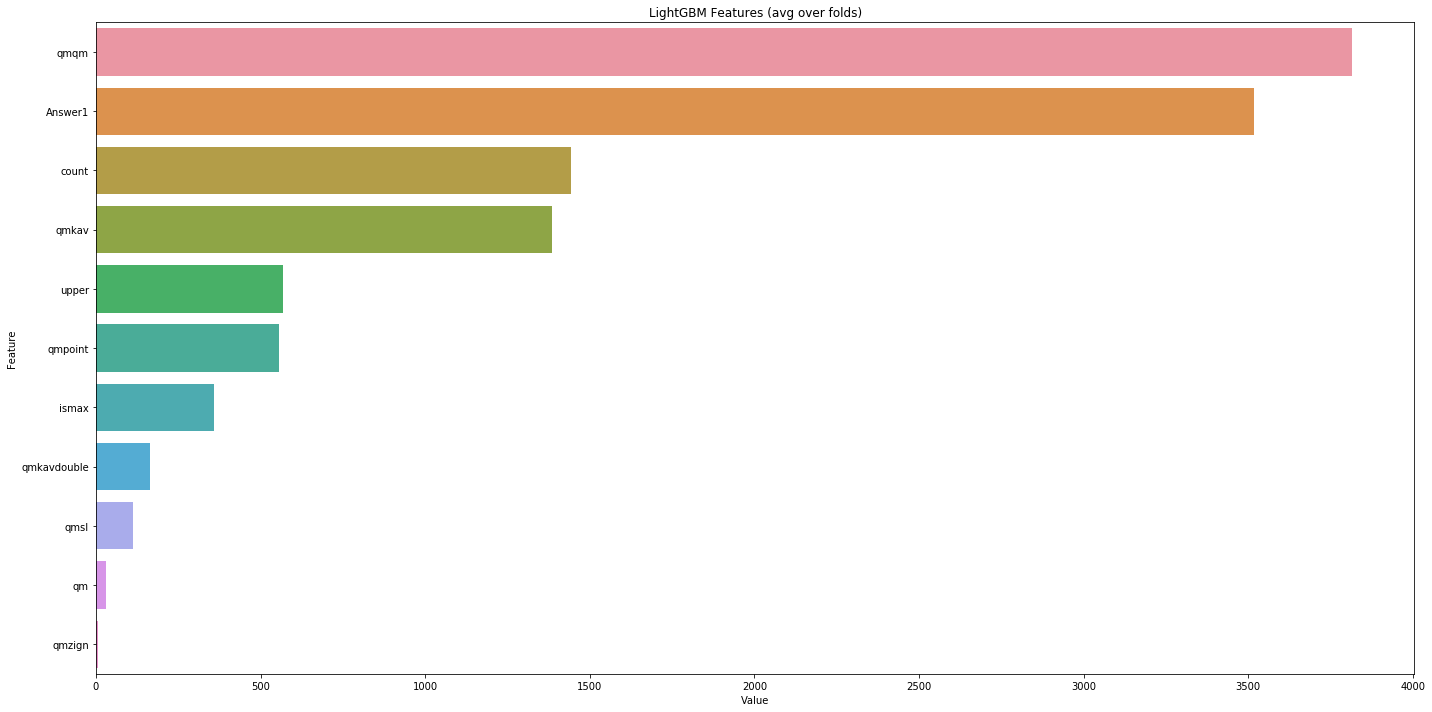

<Figure size 432x288 with 0 Axes>

In [135]:

warnings.simplefilter(action='ignore', category=FutureWarning)


feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [136]:
test1.head()

,ID,Question,Answer1,Answer,text,count,ismax,inbook,upper,qm,qmsl,qmpoint,qmqm,qmzign,qmkav,errors,qmkavdouble
0,30001,"Что в литературе обозначает слово ""эпитет""?",0.001828,-1,"Что в литературе обозначает слово ""эпитет""?",1,1,0,0,0.0,0.046512,0.0,0.023256,0.0,0.000000,0,0.0
1,30002,Когда отмечается ДЕНЬ ШОКОЛАДА,0.000658,-1,Когда отмечается ДЕНЬ ШОКОЛАДА,1,1,0,2,0.0,0.000000,0.0,0.000000,0.0,0.000000,0,0.0
2,30003,Кто из этих бодибилдеров играл Халка,0.000273,-1,Кто из этих бодибилдеров играл Халка,1,1,0,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0,0.0
3,30004,"Последняя на данный момент страна, официально ...",0.000168,-1,"Последняя на данный момент страна, официально ...",1,1,0,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0,0.0
4,30005,Как зовут лютоволка Арьи Старк из сериала «Иг...,0.668377,-1,Как зовут лютоволка Арьи Старк из сериала «Иг...,1,1,0,0,0.0,0.000000,0.0,0.016667,0.0,0.016667,0,0.0


In [137]:
test1['ID']= test1['ID'].apply(int)


test1["Answer"] = model.predict(test1[columns])

In [138]:
test.head(n=5)

,ID,Question,Answer1,Answer,text
0,30001,"Что в литературе обозначает слово ""эпитет""?",0.001828,-1,"Что в литературе обозначает слово ""эпитет""?"
1,30002,Когда отмечается ДЕНЬ ШОКОЛАДА,0.000658,-1,Когда отмечается ДЕНЬ ШОКОЛАДА
2,30003,Кто из этих бодибилдеров играл Халка,0.000273,-1,Кто из этих бодибилдеров играл Халка
3,30004,"Последняя на данный момент страна, официально ...",0.000168,-1,"Последняя на данный момент страна, официально ..."
4,30005,Как зовут лютоволка Арьи Старк из сериала «Иг...,0.668377,-1,Как зовут лютоволка Арьи Старк из сериала «Иг...


In [139]:
test1[['ID', 'Answer']].to_csv("tfidf.csv", index= None, header=None)

In [140]:
test[['ID', 'Answer']].to_csv("tfidf_.csv", index= None, header=None)